In [1]:
import copy
import random 
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import RandomUniform, RandomNormal, Zeros, Constant

from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
def create_value_model():
    value_model = Sequential()
    initializer = None
  
    # field size + planned move + own token
    input_size = 9 + 1

    value_model.add(Dense(18, input_shape=(input_size,), activation='relu', kernel_initializer=initializer))
    value_model.add(Dense(18, activation='relu', kernel_initializer=initializer))
    value_model.add(Dense(1, activation='linear', kernel_initializer=initializer))
    
    value_model.compile(loss='mean_squared_error', optimizer='sgd')
    print(value_model.summary())
    
    return value_model

In [3]:
class Board:
    def __init__(self):
        self.history = pd.DataFrame({ 'X': [0], 'O': [0], 'Draw': [0] })
        self.field = np.full((3,3), 0)
        
    def reset(self):
        self.field = np.full((3,3), 0)

    def get_board_flatten(self):
        return self.field.flatten().tolist()
    
    def get_board_flatten_with_move(self, x, y, token):
        board_copy = np.copy(self.field)
        board_copy[x][y] = token
        return board_copy.flatten().tolist()

    def print_board(self):
        print("")
        for x in range(len(self.field)):
            buffer = ""
            for y in range(len(self.field)):
                buffer += "X" if self.field[x][y] == -1 else "O" if self.field[x][y] == 1 else "-"
            print(buffer)

    def make_move(self, x, y, token):
        if self.field[x][y] == 0:
            self.field[x][y] = token

    def get_possible_moves(self):
        result = []
        for x in range(len(self.field)):
            for y in range(len(self.field)):
                if self.field[x][y] == 0:
                    result.append((x,y))
        return result
    
    def did_player_win(self, token):
        res0 = np.all(self.field == token, axis=0)
        res1 = np.all(self.field == token, axis=1)
        res_dia_0 = [np.all(self.field.diagonal() == token)]
        res_dia_1 = [np.all(np.flip(self.field, 0).diagonal() == token)]
        res = np.concatenate((res0,res1,res_dia_0,res_dia_1))

        return len([value for value in res if value == True]) > 0
    
    def add_history_element(self, winner_token):
        X = self.history.X.values[-1]
        O = self.history.O.values[-1]
        Draw = self.history.Draw.values[-1]
        
        if winner_token == 0:
            Draw += 1
        if winner_token == -1:
            X += 1
        if winner_token == 1:
            O += 1
        item = pd.DataFrame({ 'X': [X], 'O': [O], 'Draw': [Draw] })
        self.history = self.history.append(item, ignore_index=True)
    
    def get_winner_token(self, agend1, agend2):
        if self.did_player_win(agend1.token):
            return agend1.token
        if self.did_player_win(agend2.token):
            return agend2.token
        else:
            return 0

    def did_game_end(self):
        return self.did_player_win(-1) or self.did_player_win(1) or len(self.get_possible_moves()) <= 0
    
    def print_stats(self):
        nyc_chart = sns.lineplot(data=self.history).set_title('Game Stats')
        plt.show()

print("Done")

# board = Board()
# board.add_history_element(-1)
# board.print_stats()
# board.get_board_flatten_with_move(2,0,-1)

Done


In [4]:
def flip(history, axis):
    res = np.reshape(history[:9], (3, 3))
    res = np.flip(res, axis=axis)
    return np.append(res.flatten(), history[9])

class Agent:
    def __init__(self, token, auto=True, print_stats=False, epsilon=0.2):
        self.history = []
        self.auto = auto

        # 0 epsilon = no random actions
        self.epsilon = epsilon
        self.print_stats = print_stats

        if token == "X":
            self.token = -1
        else:
            self.token = 1
    
    def adjust_model(self, board, model, winning_token):
        y = []

        if (winning_token == self.token):
            # winner!
            reward = 1
            for idx, _ in enumerate(self.history):
                y.append(max(0,reward-(idx * 0.2)))
        elif (winning_token == 0):
            # draw
            reward = 1
            for idx, _ in enumerate(self.history):
                y.append(max(0,reward-(idx * 0.5)))
        else:
            # loser
            reward = -1
            for idx, _ in enumerate(self.history):
                y.append(min(0,reward+(idx * 0.2)))

        X = np.array([hist[2] for hist in self.history[::1]])
        y = np.flip(np.array(y))
        
        # rotate the board to get additional training data 
        X_flip_diagonal = np.array([flip(item, axis=None) for item in X])
        X_flip_0 = np.array([flip(item, axis=0) for item in X])
        X_flip_1 = np.array([flip(item, axis=1) for item in X])
        X = np.concatenate((X, X_flip_diagonal, X_flip_0, X_flip_1), axis=0)
        y = np.concatenate((y,y,y,y), axis=0)

        # reverse the moves and players
        X = np.concatenate((X,X * -1), axis=0)
        y = np.concatenate((y,y), axis=0)

        if self.print_stats:
            print(X)
            print(y)

        model.fit(X,y, batch_size=1, epochs=1, validation_split=0, shuffle=False, verbose=0)
        self.history = []


    def make_move_manually(self):
        user_input = input().split(",")
        x = int(user_input[0])
        y = int(user_input[1])
        
        vec = board.get_board_flatten()
        # add own token
        vec.append(self.token)
        self.history.append([1, (x,y), vec])
        # make the move
        board.make_move(x, y, self.token)

    def make_move(self, board, model):
        # get possible moves
        possible_moves = board.get_possible_moves()

        if len(possible_moves) > 0:
            take_random_move = random.random() >= (1 - self.epsilon)

            value_vectors = []
            # calculate the value for each possible move
            for [x,y] in possible_moves:
                vec = board.get_board_flatten_with_move(x,y, self.token)
                # add own token
                vec.append(self.token)
                # add to possible actions
                value_vectors.append(vec)

            values = []
            for idx, pred in enumerate(model.predict(value_vectors)):
                values.append([pred[0], possible_moves[idx], value_vectors[idx]])

            if self.auto == False:
                self.make_move_manually()
                return

            np.random.shuffle(values) 
            if take_random_move == False:
                # sort values
                values = sorted(values, key=(lambda tup: tup[0]*-1))

            if self.print_stats:
                print("Is random move:", take_random_move)
                print("\n".join(["{0:.2f}, {1}".format(perc, move) for [perc, move, board_state] in values]))

            # select move with highest value
            best_move = values[0][1]
            board.make_move(best_move[0], best_move[1], self.token)
            # store the move in the history
            self.history.append(values[0])

# board = Board()
# value_model = create_value_model()
# agent_X = Agent("X", epsilon=1, print_stats=True)
# agent_X.make_move(board, value_model)
# board.print_board()

print(np.array([-1,0,0, 0,0,0, 0,0,0, -1]))
print(flip(np.array([-1,0,0, 0,0,0, 0,0,0, -1]), axis=0))
print(flip(np.array([-1,0,0, 0,0,0, 0,0,0, -1]), axis=1))
print(flip(np.array([-1,0,0, 0,0,0, 0,0,0, -1]), axis=None))


[-1  0  0  0  0  0  0  0  0 -1]
[ 0  0  0  0  0  0 -1  0  0 -1]
[ 0  0 -1  0  0  0  0  0  0 -1]
[ 0  0  0  0  0  0  0  0 -1 -1]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                198       
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 19        
Total params: 559
Trainable params: 559
Non-trainable params: 0
_________________________________________________________________
None
done: 10 - epsilon X: 1.0 - epsilon O: 1.0
done: 20 - epsilon X: 1.0 - epsilon O: 1.0
done: 30 - epsilon X: 1.0 - epsilon O: 1.0
done: 40 - epsilon X: 1.0 - epsilon O: 1.0
done: 50 - epsilon X: 1.0 - epsilon O: 1.0
done: 60 - epsilon X: 1.0 - epsilon O: 1.0
done: 70 - epsilon X: 1.0 - epsilon O: 1.0
done: 80 - epsilon X: 1.0 - epsilon O: 1.0
done: 90 - epsilon X: 1.0 - epsilon O: 

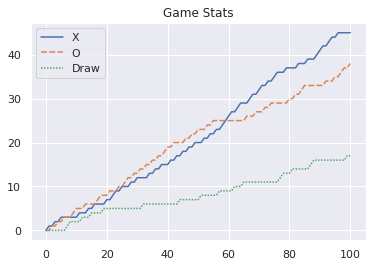

done: 110 - epsilon X: 0.5 - epsilon O: 0.5
done: 120 - epsilon X: 0.5 - epsilon O: 0.5
done: 130 - epsilon X: 0.5 - epsilon O: 0.5
done: 140 - epsilon X: 0.5 - epsilon O: 0.5
done: 150 - epsilon X: 0.5 - epsilon O: 0.5
done: 160 - epsilon X: 0.5 - epsilon O: 0.5
done: 170 - epsilon X: 0.5 - epsilon O: 0.5
done: 180 - epsilon X: 0.5 - epsilon O: 0.5
done: 190 - epsilon X: 0.5 - epsilon O: 0.5
done: 200 - epsilon X: 0.5 - epsilon O: 0.5


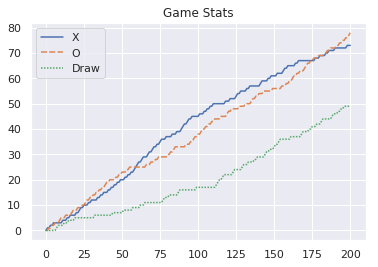

done: 210 - epsilon X: 0.1 - epsilon O: 0.1
done: 220 - epsilon X: 0.1 - epsilon O: 0.1
done: 230 - epsilon X: 0.1 - epsilon O: 0.1
done: 240 - epsilon X: 0.1 - epsilon O: 0.1
done: 250 - epsilon X: 0.1 - epsilon O: 0.1
done: 260 - epsilon X: 0.1 - epsilon O: 0.1
done: 270 - epsilon X: 0.1 - epsilon O: 0.1
done: 280 - epsilon X: 0.1 - epsilon O: 0.1
done: 290 - epsilon X: 0.1 - epsilon O: 0.1
done: 300 - epsilon X: 0.1 - epsilon O: 0.1


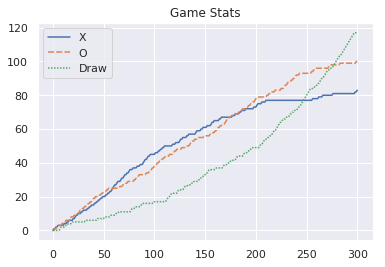

done: 310 - epsilon X: 0.1 - epsilon O: 0.1
done: 320 - epsilon X: 0.1 - epsilon O: 0.1
done: 330 - epsilon X: 0.1 - epsilon O: 0.1
done: 340 - epsilon X: 0.1 - epsilon O: 0.1
done: 350 - epsilon X: 0.1 - epsilon O: 0.1
done: 360 - epsilon X: 0.1 - epsilon O: 0.1
done: 370 - epsilon X: 0.1 - epsilon O: 0.1
done: 380 - epsilon X: 0.1 - epsilon O: 0.1
done: 390 - epsilon X: 0.1 - epsilon O: 0.1
done: 400 - epsilon X: 0.1 - epsilon O: 0.1


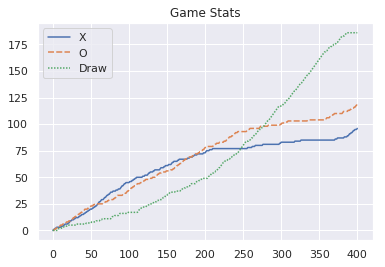

done: 410 - epsilon X: 0.1 - epsilon O: 0.1
done: 420 - epsilon X: 0.1 - epsilon O: 0.1
done: 430 - epsilon X: 0.1 - epsilon O: 0.1
done: 440 - epsilon X: 0.1 - epsilon O: 0.1
done: 450 - epsilon X: 0.1 - epsilon O: 0.1
done: 460 - epsilon X: 0.1 - epsilon O: 0.1
done: 470 - epsilon X: 0.1 - epsilon O: 0.1
done: 480 - epsilon X: 0.1 - epsilon O: 0.1
done: 490 - epsilon X: 0.1 - epsilon O: 0.1
done: 500 - epsilon X: 0.1 - epsilon O: 0.1


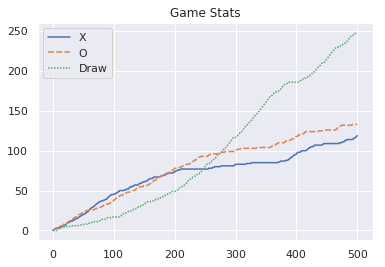

done: 510 - epsilon X: 0.1 - epsilon O: 0.1
done: 520 - epsilon X: 0.1 - epsilon O: 0.1
done: 530 - epsilon X: 0.1 - epsilon O: 0.1
done: 540 - epsilon X: 0.1 - epsilon O: 0.1
done: 550 - epsilon X: 0.1 - epsilon O: 0.1
done: 560 - epsilon X: 0.1 - epsilon O: 0.1
done: 570 - epsilon X: 0.1 - epsilon O: 0.1
done: 580 - epsilon X: 0.1 - epsilon O: 0.1
done: 590 - epsilon X: 0.1 - epsilon O: 0.1
done: 600 - epsilon X: 0.1 - epsilon O: 0.1


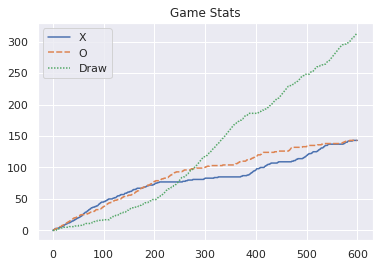

done: 610 - epsilon X: 0.1 - epsilon O: 0.1
done: 620 - epsilon X: 0.1 - epsilon O: 0.1
done: 630 - epsilon X: 0.1 - epsilon O: 0.1
done: 640 - epsilon X: 0.1 - epsilon O: 0.1
done: 650 - epsilon X: 0.1 - epsilon O: 0.1
done: 660 - epsilon X: 0.1 - epsilon O: 0.1
done: 670 - epsilon X: 0.1 - epsilon O: 0.1
done: 680 - epsilon X: 0.1 - epsilon O: 0.1
done: 690 - epsilon X: 0.1 - epsilon O: 0.1
done: 700 - epsilon X: 0.1 - epsilon O: 0.1


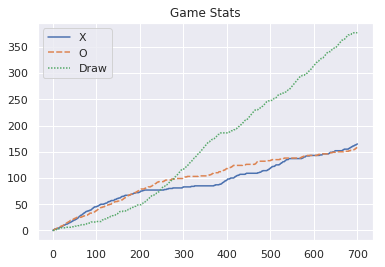

done: 710 - epsilon X: 0.1 - epsilon O: 0.1
done: 720 - epsilon X: 0.1 - epsilon O: 0.1
done: 730 - epsilon X: 0.1 - epsilon O: 0.1
done: 740 - epsilon X: 0.1 - epsilon O: 0.1
done: 750 - epsilon X: 0.1 - epsilon O: 0.1
done: 760 - epsilon X: 0.1 - epsilon O: 0.1
done: 770 - epsilon X: 0.1 - epsilon O: 0.1
done: 780 - epsilon X: 0.1 - epsilon O: 0.1
done: 790 - epsilon X: 0.1 - epsilon O: 0.1
done: 800 - epsilon X: 0.1 - epsilon O: 0.1


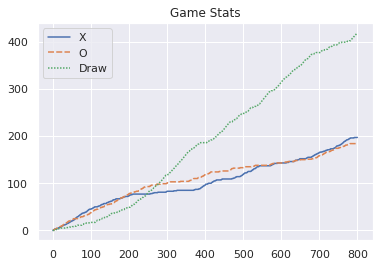

done: 810 - epsilon X: 0.1 - epsilon O: 0.1
done: 820 - epsilon X: 0.1 - epsilon O: 0.1
done: 830 - epsilon X: 0.1 - epsilon O: 0.1
done: 840 - epsilon X: 0.1 - epsilon O: 0.1
done: 850 - epsilon X: 0.1 - epsilon O: 0.1
done: 860 - epsilon X: 0.1 - epsilon O: 0.1
done: 870 - epsilon X: 0.1 - epsilon O: 0.1
done: 880 - epsilon X: 0.1 - epsilon O: 0.1
done: 890 - epsilon X: 0.1 - epsilon O: 0.1
done: 900 - epsilon X: 0.1 - epsilon O: 0.1


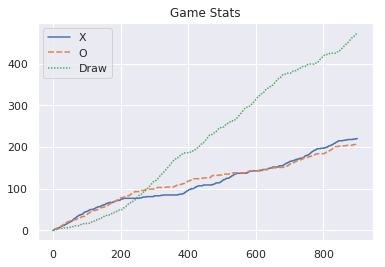

done: 910 - epsilon X: 0.1 - epsilon O: 0.1
done: 920 - epsilon X: 0.1 - epsilon O: 0.1
done: 930 - epsilon X: 0.1 - epsilon O: 0.1
done: 940 - epsilon X: 0.1 - epsilon O: 0.1
done: 950 - epsilon X: 0.1 - epsilon O: 0.1
done: 960 - epsilon X: 0.1 - epsilon O: 0.1
done: 970 - epsilon X: 0.1 - epsilon O: 0.1
done: 980 - epsilon X: 0.1 - epsilon O: 0.1
done: 990 - epsilon X: 0.1 - epsilon O: 0.1
done: 1000 - epsilon X: 0.1 - epsilon O: 0.1


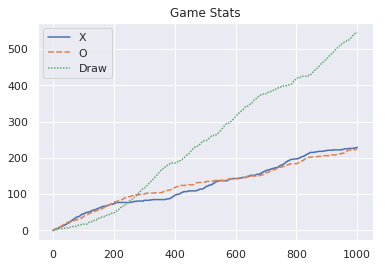

done: 1010 - epsilon X: 0.1 - epsilon O: 0.1
done: 1020 - epsilon X: 0.1 - epsilon O: 0.1
done: 1030 - epsilon X: 0.1 - epsilon O: 0.1
done: 1040 - epsilon X: 0.1 - epsilon O: 0.1
done: 1050 - epsilon X: 0.1 - epsilon O: 0.1
done: 1060 - epsilon X: 0.1 - epsilon O: 0.1
done: 1070 - epsilon X: 0.1 - epsilon O: 0.1
done: 1080 - epsilon X: 0.1 - epsilon O: 0.1
done: 1090 - epsilon X: 0.1 - epsilon O: 0.1
done: 1100 - epsilon X: 0.1 - epsilon O: 0.1


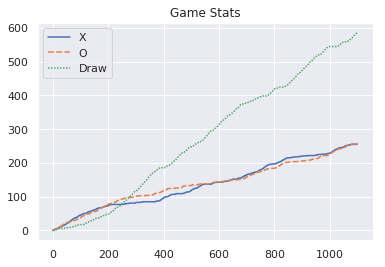

done: 1110 - epsilon X: 0.1 - epsilon O: 0.1
done: 1120 - epsilon X: 0.1 - epsilon O: 0.1
done: 1130 - epsilon X: 0.1 - epsilon O: 0.1
done: 1140 - epsilon X: 0.1 - epsilon O: 0.1
done: 1150 - epsilon X: 0.1 - epsilon O: 0.1
done: 1160 - epsilon X: 0.1 - epsilon O: 0.1
done: 1170 - epsilon X: 0.1 - epsilon O: 0.1
done: 1180 - epsilon X: 0.1 - epsilon O: 0.1
done: 1190 - epsilon X: 0.1 - epsilon O: 0.1
done: 1200 - epsilon X: 0.1 - epsilon O: 0.1


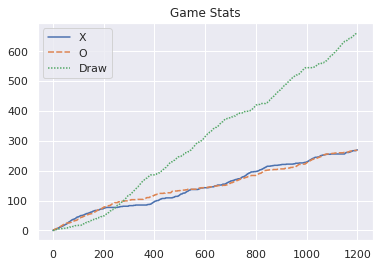

done: 1210 - epsilon X: 0.1 - epsilon O: 0.1
done: 1220 - epsilon X: 0.1 - epsilon O: 0.1
done: 1230 - epsilon X: 0.1 - epsilon O: 0.1
done: 1240 - epsilon X: 0.1 - epsilon O: 0.1
done: 1250 - epsilon X: 0.1 - epsilon O: 0.1
done: 1260 - epsilon X: 0.1 - epsilon O: 0.1
done: 1270 - epsilon X: 0.1 - epsilon O: 0.1
done: 1280 - epsilon X: 0.1 - epsilon O: 0.1
done: 1290 - epsilon X: 0.1 - epsilon O: 0.1
done: 1300 - epsilon X: 0.1 - epsilon O: 0.1


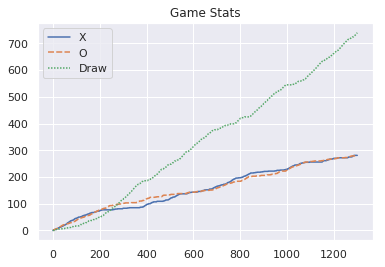

done: 1310 - epsilon X: 0.1 - epsilon O: 0.1
done: 1320 - epsilon X: 0.1 - epsilon O: 0.1
done: 1330 - epsilon X: 0.1 - epsilon O: 0.1
done: 1340 - epsilon X: 0.1 - epsilon O: 0.1
done: 1350 - epsilon X: 0.1 - epsilon O: 0.1
done: 1360 - epsilon X: 0.1 - epsilon O: 0.1
done: 1370 - epsilon X: 0.1 - epsilon O: 0.1
done: 1380 - epsilon X: 0.1 - epsilon O: 0.1
done: 1390 - epsilon X: 0.1 - epsilon O: 0.1
done: 1400 - epsilon X: 0.1 - epsilon O: 0.1


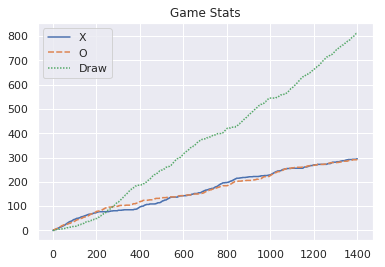

done: 1410 - epsilon X: 0.1 - epsilon O: 0.1
done: 1420 - epsilon X: 0.1 - epsilon O: 0.1
done: 1430 - epsilon X: 0.1 - epsilon O: 0.1
done: 1440 - epsilon X: 0.1 - epsilon O: 0.1
done: 1450 - epsilon X: 0.1 - epsilon O: 0.1
done: 1460 - epsilon X: 0.1 - epsilon O: 0.1
done: 1470 - epsilon X: 0.1 - epsilon O: 0.1
done: 1480 - epsilon X: 0.1 - epsilon O: 0.1
done: 1490 - epsilon X: 0.1 - epsilon O: 0.1
done: 1500 - epsilon X: 0.1 - epsilon O: 0.1


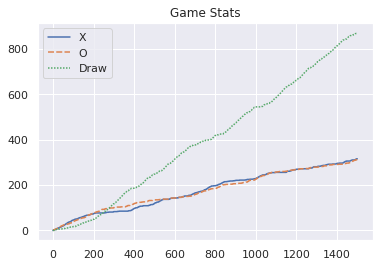

Done


In [5]:
value_model = create_value_model()

def train_agent():
    agent_X = Agent("X", print_stats=False, epsilon=0.1, auto=True)
    agent_O = Agent("O", print_stats=False, epsilon=0.1, auto=True)
    
    players = [agent_X, agent_O]
    player_id = 0
    board = Board()

    rounds = 1500
    for i in range(rounds):

        # default agent epsilon
        agent_X.epsilon = 0.1
        agent_O.epsilon = 0.1

        if i < 200:
            agent_X.epsilon = 0.5
            agent_O.epsilon = 0.5

        if i < 100:
            agent_X.epsilon = 1.0
            agent_O.epsilon = 1.0

        board.reset()

        while(board.did_game_end() == False):
            players[player_id].make_move(board, value_model)
            player_id = (player_id + 1) % 2

        # add history
        winning_token = board.get_winner_token(agent_X, agent_O)
        board.add_history_element(winning_token)

        # adjust the network
        agent_X.adjust_model(board, value_model, winning_token)
        agent_O.adjust_model(board, value_model, winning_token)
        
        if (i % 10) == 9:
            print("done:", i + 1, "- epsilon X:", agent_X.epsilon, "- epsilon O:", agent_O.epsilon)
            
        if (i % 100) == 99:
            board.print_stats()

train_agent()
print("Done")

In [6]:
agent_X = Agent("X", print_stats=True, epsilon=0, auto=True)
agent_O = Agent("O", print_stats=True, epsilon=0, auto=True)
    
players = [agent_X, agent_O]
player_id = 0
board = Board()
model = value_model

while True:
    player_id = 0
    board.reset()

    while(board.did_game_end() == False):
        players[player_id].make_move(board, model)
        board.print_board()
        player_id = (player_id + 1) % 2

    board.print_board()

    winning_token = board.get_winner_token(agent_X, agent_O)
    print("Token:", winning_token)

    agent_X.adjust_model(board, model, winning_token)
    agent_O.adjust_model(board, model, winning_token)

    break

Is random move: False
-0.05, (1, 1)
-0.14, (2, 2)
-0.14, (0, 2)
-0.15, (0, 0)
-0.17, (0, 1)
-0.17, (2, 1)
-0.18, (2, 0)
-0.19, (1, 2)
-0.20, (1, 0)

---
-X-
---
Is random move: False
-0.24, (1, 2)
-0.25, (1, 0)
-0.25, (2, 0)
-0.26, (0, 1)
-0.26, (0, 2)
-0.26, (2, 1)
-0.26, (0, 0)
-0.26, (2, 2)

---
-XO
---
Is random move: False
0.12, (0, 2)
0.11, (2, 1)
0.10, (0, 1)
0.09, (2, 2)
0.07, (2, 0)
0.06, (1, 0)
0.04, (0, 0)

--X
-XO
---
Is random move: False
-0.19, (2, 0)
-0.20, (1, 0)
-0.20, (0, 0)
-0.21, (2, 2)
-0.22, (0, 1)
-0.26, (2, 1)

--X
-XO
O--
Is random move: False
0.21, (2, 1)
0.21, (2, 2)
0.19, (1, 0)
0.18, (0, 1)
0.18, (0, 0)

--X
-XO
OX-
Is random move: False
0.25, (0, 1)
-0.02, (0, 0)
-0.15, (2, 2)
-0.21, (1, 0)

-OX
-XO
OX-
Is random move: False
0.56, (1, 0)
0.32, (0, 0)
0.25, (2, 2)

-OX
XXO
OX-
Is random move: False
0.78, (0, 0)
0.62, (2, 2)

OOX
XXO
OX-
Is random move: False
0.98, (2, 2)

OOX
XXO
OXX

OOX
XXO
OXX
Token: 0
[[ 0  0  0  0 -1  0  0  0  0 -1]
 [ 0  0 -1  0 -1  1

In [7]:
value_model.save("tic-tac-toe-agent.h5")